In [45]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

In [46]:
df = pd.read_csv('[stock_name].csv')

In [47]:
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1999-01-22') # Insert Start Date
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [48]:
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

In [59]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2023-01-01', # Instert start date
                                '2024-02-16', # Intert end date
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2023-01-01,141.210007,140.360001,146.029999,146.139999
1,2023-01-04,146.029999,146.139999,143.149994,147.490005
2,2023-01-05,146.139999,143.149994,147.490005,142.649994
3,2023-01-06,143.149994,147.490005,142.649994,148.589996
4,2023-01-09,147.490005,142.649994,148.589996,156.279999
...,...,...,...,...,...
278,2024-02-12,700.989990,696.409973,721.330017,722.479980
279,2024-02-13,696.409973,721.330017,722.479980,721.280029
280,2024-02-14,721.330017,722.479980,721.280029,739.000000
281,2024-02-15,722.479980,721.280029,739.000000,726.580017


In [60]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((283,), (283, 3, 1), (283,))

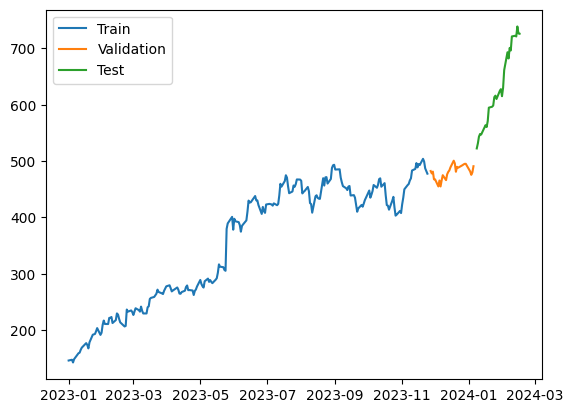

In [61]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 2s 46ms/step - loss: 135982.7188 - mean_absolute_error: 353.2579 - val_loss: 230310.2656 - val_mean_absolute_error: 479.7539
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 135563.2500 - mean_absolute_error: 352.6762 - val_loss: 229769.8906 - val_mean_absolute_error: 479.1905
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 135124.6875 - mean_absolute_error: 352.0514 - val_loss: 229074.8750 - val_mean_absolute_error: 478.4647
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 134548.7656 - mean_absolute_error: 351.2250 - val_loss: 228122.0000 - val_mean_absolute_error: 477.4678
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 133714.8750 - mean_absolute_error: 350.0423 - val_loss: 226692.9062 - val_mean_absolute_error: 475.9690
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 132598.7344 - mean_absolute_error: 348.4489 - val_los

8/8 [==============================] - 0s 1ms/step


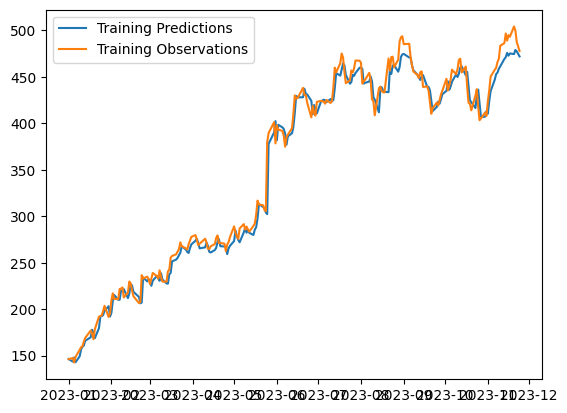

In [63]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

1/1 [==============================] - 0s 20ms/step


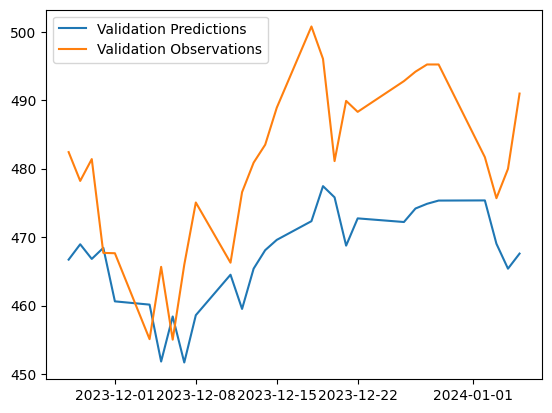

In [64]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 [==============================] - 0s 15ms/step


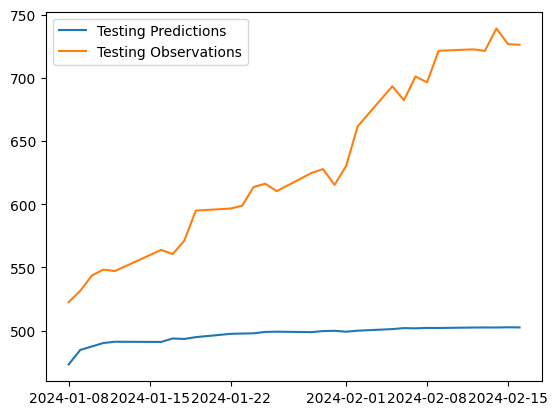

In [65]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

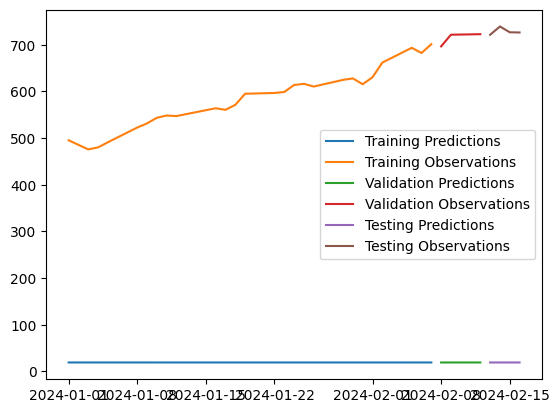

In [56]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [66]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

1/1 [==============================] - 0s 17ms/step


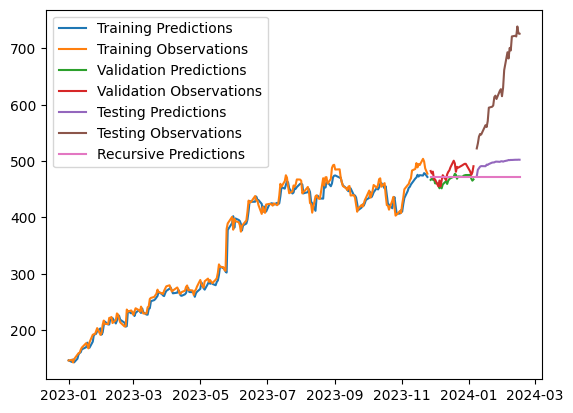

In [67]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])